In [1]:
import numpy as np
import pandas as pd
import folium
import matplotlib.pyplot as plt

In [2]:
country_geo = 'datasets/all_countries.geo.json'

In [3]:
## Gather all sets
covid_data = pd.read_csv('datasets/COVID-19-worldwide.csv')
pop_dens = pd.read_csv('datasets/population_density.csv')
tourism_data = pd.read_csv('datasets/tourism_data.csv')
#sqmt = pd.read_csv('datasets/squaremeter_per_country.csv')
urban_area = pd.read_csv('datasets/urban_landarea.csv')
urban_pop = pd.read_csv('datasets/urban_pop.csv')
rural_pop = pd.read_csv('datasets/rural_pop.csv')
trust_in_pol = pd.read_csv('datasets/trust_in_politicians.csv')
gov_eff = pd.read_csv('datasets/gov_effectiveness.csv')
age_pop = pd.read_csv('datasets/pop_percentage_over_65.csv')


## Set correct indices
trust_in_pol.set_index('Country ISO3',inplace=True)
gov_eff.set_index('Country ISO3',inplace=True)
rural_pop.set_index('Country Code',inplace=True)
urban_pop.set_index('Country Code',inplace=True)
tourism_data.set_index('Country Code',inplace=True)
pop_dens.set_index('Country Code',inplace=True)
urban_area.set_index('Country Code',inplace=True)
age_pop.set_index('Country Code',inplace=True)

In [4]:
# Clean datasets
trust_in_pol = trust_in_pol.loc[(trust_in_pol['Indicator'] == 'Public trust in politicians') & (trust_in_pol['Subindicator Type'] == '1-7 Best')]
trust_in_pol = trust_in_pol[['Country Name','2017-2018']]
trust_in_pol['2017-2018'] = trust_in_pol['2017-2018'].round(3);

gov_stats = gov_eff[['Country Name','Indicator','Subindicator Type','2018']]
gov_stats_corruption = gov_stats.loc[(gov_stats['Indicator'] == 'Control of Corruption') & (gov_stats['Subindicator Type'] == 'Estimate')]
gov_stats_effectiveness = gov_stats.loc[(gov_stats['Indicator'] == 'Government Effectiveness') & (gov_stats['Subindicator Type'] == 'Estimate')]
gov_stats_rule = gov_stats.loc[(gov_stats['Indicator'] == 'Rule of Law') & (gov_stats['Subindicator Type'] == 'Estimate')]
gov_stats_reg = gov_stats.loc[(gov_stats['Indicator'] == 'Regulatory Quality') & (gov_stats['Subindicator Type'] == 'Estimate')]
gov_stats_full = gov_stats_corruption.append([gov_stats_effectiveness,gov_stats_rule,gov_stats_reg])
gov_stats_full.sort_index()
gov_stats_full.dropna(inplace=True)

rural_2018 = rural_pop[['Country Name','2018']]
rural_2018 = rural_2018.drop(index=['SSF','WLD','HIC','OED','PST','ECS','IBT','LMY','EUU','MIC',
                                    'IBD','EMU','UMC','LTE','EAS','EAR','TEC','EAP','TEA','ECA',
                                    'LMC','LCN','MEA','ARB','NAC','TLA','CEB','LAC','MNA','TMN',
                                    'SST','OSS','LDC','TSA','SAS','TSS','SSA','FCS','HPC','PRE'])

urban_2018 = urban_pop[['Country Name','2018']]
urban_2018 = urban_2018.drop(index=['SSF','WLD','HIC','OED','PST','ECS','IBT','LMY','EUU','MIC',
                                    'IBD','EMU','UMC','LTE','EAS','EAR','TEC','EAP','TEA','ECA',
                                    'LMC','LCN','MEA','ARB','NAC','TLA','CEB','LAC','MNA','TMN',
                                    'SST','OSS','LDC','TSA','SAS','TSS','SSA','FCS','HPC','PRE'])

pop_dens = pop_dens[['Country Name','2018']]
tourism_data = tourism_data[['Country Name', '2018']]
t_data = tourism_data.drop(index=['WLD','HIC','OED','PST','ECS','IBT','LMY','EUU','MIC','IBD','EMU',
                            'UMC','LTE','EAS','EAR','TEC','EAP','TEA','ECA','LMC','LCN','MEA',
                            'ARB','NAC','TLA','CEB','LAC','MNA','TMN','SST','OSS','LDC','TSA',
                            'SAS'])

In [5]:
day_to_analyze = '5/10/2020'

In [6]:
pop_dens.sort_values('2018', ascending=False)

,Country Name,2018
Country Code,,
MAC,"Macao SAR, China",20777.500261
SGP,Singapore,7952.998418
HKG,"Hong Kong SAR, China",7096.190476
GIB,Gibraltar,3371.800000
BHR,Bahrain,2017.273700
...,...,...
MCO,Monaco,NaN
SDN,Sudan,NaN
SSD,South Sudan,NaN


In [7]:
t = covid_data.groupby('countryterritoryCode').count()
new_df = covid_data
new_df = new_df.set_index('countryterritoryCode')
new_df['total_deaths'] = 0
new_df['total_cases'] = 0
new_df['deaths_per_100k'] = 0
new_df['cases_per_100k'] = 0
new_df['current_infection_rate'] = 0
new_df['tourists_per_100k'] = 0
new_df['urban_pop_per_100k'] = 0
new_df['rural_percent'] = 0
new_df['trust_in_politicians'] = 0
new_df['rule_of_law'] = 0
new_df['gov_effectiveness'] = 0
new_df['reg_quality'] = 0
new_df['corruption_control'] = 0
new_df['average_infection_rate'] = 0
new_df['pop_percentage_over_65'] = 0
new_df['pop_percentage_over_65_per_100k'] = 0

new_df = new_df[::-1]

for idx, row in t.iterrows():
    new_df.loc[[idx],['total_deaths']] = new_df.loc[idx]['deaths'].cumsum(axis=0)
    new_df.loc[[idx],['total_cases']] = new_df.loc[idx]['cases'].cumsum(axis=0)
    
    new_df.loc[[idx],['deaths_per_100k']] = (100000 * (new_df.loc[idx]['total_deaths'] / new_df.loc[idx]['popData2018'])).round(3)
    new_df.loc[[idx],['cases_per_100k']] = (100000 * (new_df.loc[idx]['total_cases'] / new_df.loc[idx]['popData2018'])).round(3)
    
    if(idx in urban_2018.index):
        new_df.loc[[idx],['urban_pop_per_100k']] = (100000 * (urban_2018.loc[idx]['2018'] / new_df.loc[idx]['popData2018'])).round(3)
        
    if(idx in rural_2018.index):
        new_df.loc[[idx],['rural_percent']] = rural_2018.loc[idx]['2018']

    if(idx in trust_in_pol.index):
        new_df.loc[[idx],['trust_in_politicians']] = trust_in_pol.loc[idx]['2017-2018']
        
    if(idx in gov_stats_full.index):
        new_df.loc[[idx],['rule_of_law']] = gov_stats_rule.loc[idx]['2018']
        new_df.loc[[idx],['gov_effectiveness']] = gov_stats_effectiveness.loc[idx]['2018']
        new_df.loc[[idx],['reg_quality']] = gov_stats_corruption.loc[idx]['2018']
        new_df.loc[[idx],['corruption_control']] = gov_stats_reg.loc[idx]['2018']
    
    if(idx in tourism_data.index):
        tourists_total = tourism_data.loc[idx]['2018']
        new_df.loc[[idx],['tourists_per_100k']] = 100000*(tourists_total / new_df.loc[idx]['popData2018']).round(3)

    if(idx in age_pop.index):
        age_pop_total = age_pop.loc[idx]['2018']
        new_df.loc[[idx],['pop_percentage_over_65']] = age_pop_total
        new_df.loc[[idx],['pop_percentage_over_65_per_100k']] = (100000*age_pop_total*0.01).round(3)
    
    
    
    
for i in range(2,len(new_df)):
    current_country = new_df.iloc[i].name
    previous_country = new_df.iloc[i-1].name
    if(current_country == previous_country):
        previous_cases = new_df.iloc[i-1,new_df.columns.get_loc('cases')]
        current_cases = new_df.iloc[i,new_df.columns.get_loc('cases')]
        # Avoiding zero-division
        if(previous_cases > 0 and current_cases > 0):
            new_df.iloc[i,new_df.columns.get_loc('current_infection_rate')] = (current_cases / previous_cases).round(1)

for idx, row in t.iterrows():
    new_df.loc[[idx],['average_infection_rate']] = (1000 * new_df.loc[idx]['current_infection_rate'].mean())
            
new_df = new_df[::-1]

In [8]:
full_set = new_df.drop(columns=['day','month','year','cases','deaths'])

In [9]:
full_set.head()

,dateRep,countriesAndTerritories,geoId,popData2018,continentExp,total_deaths,total_cases,deaths_per_100k,cases_per_100k,current_infection_rate,...,urban_pop_per_100k,rural_percent,trust_in_politicians,rule_of_law,gov_effectiveness,reg_quality,corruption_control,average_infection_rate,pop_percentage_over_65,pop_percentage_over_65_per_100k
countryterritoryCode,,,,,,,,,,,,,,,,,,,,,
AFG,5/11/2020,Afghanistan,AF,37172386.0,Asia,120,4402,0.323,11.842,1.4,...,25495.001,74.505,0.0,-1.668478,-1.457285,-1.496648,-1.132634,614.634146,2.584927,2584.927
AFG,5/10/2020,Afghanistan,AF,37172386.0,Asia,115,4033,0.309,10.849,1.2,...,25495.001,74.505,0.0,-1.668478,-1.457285,-1.496648,-1.132634,614.634146,2.584927,2584.927
AFG,5/9/2020,Afghanistan,AF,37172386.0,Asia,109,3778,0.293,10.163,1.3,...,25495.001,74.505,0.0,-1.668478,-1.457285,-1.496648,-1.132634,614.634146,2.584927,2584.927
AFG,5/8/2020,Afghanistan,AF,37172386.0,Asia,106,3563,0.285,9.585,1.0,...,25495.001,74.505,0.0,-1.668478,-1.457285,-1.496648,-1.132634,614.634146,2.584927,2584.927
AFG,5/7/2020,Afghanistan,AF,37172386.0,Asia,104,3392,0.280,9.125,0.5,...,25495.001,74.505,0.0,-1.668478,-1.457285,-1.496648,-1.132634,614.634146,2.584927,2584.927


In [10]:
full_set.loc['ESP']

,dateRep,countriesAndTerritories,geoId,popData2018,continentExp,total_deaths,total_cases,deaths_per_100k,cases_per_100k,current_infection_rate,...,urban_pop_per_100k,rural_percent,trust_in_politicians,rule_of_law,gov_effectiveness,reg_quality,corruption_control,average_infection_rate,pop_percentage_over_65,pop_percentage_over_65_per_100k
countryterritoryCode,,,,,,,,,,,,,,,,,,,,,
ESP,5/10/2020,Spain,ES,46723749.0,Europe,26621,224390,56.975,480.248,1.1,...,80446.132,19.679,2.24,0.968938,1.002136,0.613507,0.94529,695.454545,19.378508,19378.508
ESP,5/9/2020,Spain,ES,46723749.0,Europe,26478,223578,56.669,478.510,0.5,...,80446.132,19.679,2.24,0.968938,1.002136,0.613507,0.94529,695.454545,19.378508,19378.508
ESP,5/8/2020,Spain,ES,46723749.0,Europe,26251,222857,56.183,476.967,1.3,...,80446.132,19.679,2.24,0.968938,1.002136,0.613507,0.94529,695.454545,19.378508,19378.508
ESP,5/7/2020,Spain,ES,46723749.0,Europe,26070,221447,55.796,473.950,1.1,...,80446.132,19.679,2.24,0.968938,1.002136,0.613507,0.94529,695.454545,19.378508,19378.508
ESP,5/6/2020,Spain,ES,46723749.0,Europe,25857,220325,55.340,471.548,0.8,...,80446.132,19.679,2.24,0.968938,1.002136,0.613507,0.94529,695.454545,19.378508,19378.508
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ESP,1/4/2020,Spain,ES,46723749.0,Europe,0,0,0.000,0.000,0.0,...,80446.132,19.679,2.24,0.968938,1.002136,0.613507,0.94529,695.454545,19.378508,19378.508
ESP,1/3/2020,Spain,ES,46723749.0,Europe,0,0,0.000,0.000,0.0,...,80446.132,19.679,2.24,0.968938,1.002136,0.613507,0.94529,695.454545,19.378508,19378.508
ESP,1/2/2020,Spain,ES,46723749.0,Europe,0,0,0.000,0.000,0.0,...,80446.132,19.679,2.24,0.968938,1.002136,0.613507,0.94529,695.454545,19.378508,19378.508


In [11]:
present_day = full_set[full_set['dateRep'] == day_to_analyze]

In [12]:
present_day.head()

,dateRep,countriesAndTerritories,geoId,popData2018,continentExp,total_deaths,total_cases,deaths_per_100k,cases_per_100k,current_infection_rate,...,urban_pop_per_100k,rural_percent,trust_in_politicians,rule_of_law,gov_effectiveness,reg_quality,corruption_control,average_infection_rate,pop_percentage_over_65,pop_percentage_over_65_per_100k
countryterritoryCode,,,,,,,,,,,,,,,,,,,,,
AFG,5/10/2020,Afghanistan,AF,37172386.0,Asia,115,4033,0.309,10.849,1.2,...,25495.001,74.505,0.000,-1.668478,-1.457285,-1.496648,-1.132634,614.634146,2.584927,2584.927
ALB,5/10/2020,Albania,AL,2866376.0,Europe,31,856,1.082,29.863,0.8,...,60318.988,39.681,3.266,-0.392243,0.114788,-0.521867,0.281710,1278.125000,13.744736,13744.736
DZA,5/10/2020,Algeria,DZ,42228429.0,Africa,494,5558,1.170,13.162,1.0,...,72629.001,27.371,2.824,-0.775309,-0.443925,-0.636465,-1.263752,654.687500,6.362497,6362.497
AND,5/10/2020,Andorra,AD,77006.0,Europe,48,754,62.333,979.144,0.0,...,88061.969,11.938,0.000,1.607738,1.944976,1.238614,1.187921,991.525424,NaN,NaN
AGO,5/10/2020,Angola,AO,30809762.0,Africa,2,43,0.006,0.140,0.0,...,65513.998,34.486,NaN,-1.048023,-1.052086,-1.144541,-0.999813,196.078431,2.216374,2216.374


In [13]:
#new_df[new_df['dateRep'] == '4/27/2020'].sort_values('urban_pop_per_100k',ascending=False)[:20]

In [14]:
bins = list(present_day['cases_per_100k'].quantile([0, 0.2, 0.4, 0.6,0.7,0.9, 1]))

In [15]:
m = folium.Map(location=[50.5260, 15.2551], zoom_start=4,zoom_control=False,
               scrollWheelZoom=False,
               dragging=False,
               doubleClickZoom=False,
               min_zoom =4,
               max_zoom =4)
folium.Choropleth(
    geo_data=country_geo,
    name='choropleth',
    data=present_day,
    columns=[present_day.index,'cases_per_100k'],
    key_on='properties.iso_a3',
    fill_color='OrRd',
    fill_opacity=0.5,
    line_opacity=0.2,
    bins=bins,
    legend_name='cases_per_100k'
).add_to(m)

In [16]:
m

In [17]:
m.save("../Final project/website/folium/map1.html")

In [18]:
full_set.corr()

,popData2018,total_deaths,total_cases,deaths_per_100k,cases_per_100k,current_infection_rate,tourists_per_100k,urban_pop_per_100k,rural_percent,trust_in_politicians,rule_of_law,gov_effectiveness,reg_quality,corruption_control,average_infection_rate,pop_percentage_over_65,pop_percentage_over_65_per_100k
popData2018,1.000000,0.103215,0.154635,-0.032148,-0.063766,0.016571,-0.110403,-0.087387,0.121957,0.153138,-0.056783,0.009651,-0.079866,-0.069385,0.094233,-0.025858,-0.025858
total_deaths,0.103215,1.000000,0.912001,0.385143,0.224274,0.014790,-0.029947,0.083577,-0.071496,0.081216,0.110831,0.117600,0.101399,0.116875,0.009122,0.152815,0.152815
total_cases,0.154635,0.912001,1.000000,0.244578,0.187790,0.015431,-0.037737,0.079405,-0.066329,0.101644,0.099885,0.115694,0.090459,0.107399,0.028229,0.123257,0.123257
deaths_per_100k,-0.032148,0.385143,0.244578,1.000000,0.757990,0.022479,0.210531,0.141771,-0.168366,-0.056599,0.128459,0.125661,0.124050,0.117660,-0.005988,0.209799,0.209799
cases_per_100k,-0.063766,0.224274,0.187790,0.757990,1.000000,0.022886,0.317490,0.100790,-0.220782,-0.079622,0.180624,0.177238,0.175255,0.160341,-0.023856,0.113199,0.113199
current_infection_rate,0.016571,0.014790,0.015431,0.022479,0.022886,1.000000,-0.005292,0.026168,-0.002799,0.030536,-0.007032,-0.000390,-0.012205,0.002595,0.178132,0.004777,0.004777
tourists_per_100k,-0.110403,-0.029947,-0.037737,0.210531,0.317490,-0.005292,1.000000,0.254069,-0.196786,-0.159604,0.230310,0.220218,0.195146,0.174183,-0.025171,0.239938,0.239938
urban_pop_per_100k,-0.087387,0.083577,0.079405,0.141771,0.100790,0.026168,0.254069,1.000000,-0.723314,0.348276,0.415230,0.443447,0.413061,0.414064,0.147529,0.495696,0.495696
rural_percent,0.121957,-0.071496,-0.066329,-0.168366,-0.220782,-0.002799,-0.196786,-0.723314,1.000000,-0.163521,-0.469912,-0.502347,-0.466654,-0.471063,-0.015782,-0.311268,-0.311268
trust_in_politicians,0.153138,0.081216,0.101644,-0.056599,-0.079622,0.030536,-0.159604,0.348276,-0.163521,1.000000,0.535544,0.569869,0.536225,0.531540,0.174816,0.348104,0.348104


In [19]:
top_list = present_day.sort_values('deaths_per_100k',ascending=True)[:20]

In [20]:
top_list

,dateRep,countriesAndTerritories,geoId,popData2018,continentExp,total_deaths,total_cases,deaths_per_100k,cases_per_100k,current_infection_rate,...,urban_pop_per_100k,rural_percent,trust_in_politicians,rule_of_law,gov_effectiveness,reg_quality,corruption_control,average_infection_rate,pop_percentage_over_65,pop_percentage_over_65_per_100k
countryterritoryCode,,,,,,,,,,,,,,,,,,,,,
NPL,5/10/2020,Nepal,NP,28087871.0,Asia,0,109,0.0,0.388,0.0,...,19740.001,80.260,1.907,-0.478053,-0.902338,-0.673651,-0.745653,65.000000,5.727671,5727.671
PNG,5/10/2020,Papua_New_Guinea,PG,8606316.0,Oceania,0,8,0.0,0.093,0.0,...,13169.003,86.831,0.000,-0.765850,-0.677340,-0.876009,-0.543365,0.000000,3.445269,3445.269
BTN,5/10/2020,Bhutan,BT,754394.0,Asia,0,7,0.0,0.928,0.0,...,40894.943,59.105,4.540,0.552093,0.358897,1.646514,-0.334626,0.000000,6.003012,6003.012
NCL,5/10/2020,New_Caledonia,NC,284060.0,Oceania,0,18,0.0,6.337,0.0,...,70682.954,29.317,0.000,0.000000,0.000000,0.000000,0.000000,138.461538,9.174158,9174.158
NaN,5/10/2020,"Bonaire, Saint Eustatius and Saba",BQ,NaN,America,0,0,0.0,0.000,0.0,...,0.000,0.000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000
DMA,5/10/2020,Dominica,DM,71625.0,America,0,16,0.0,22.339,0.0,...,70482.373,29.517,0.000,0.617601,-0.289503,0.545734,0.082073,116.000000,NaN,NaN
PYF,5/10/2020,French_Polynesia,PF,277679.0,Oceania,0,60,0.0,21.608,0.0,...,61833.988,38.166,0.000,0.000000,0.000000,0.000000,0.000000,231.481481,8.290508,8290.508
NAM,5/10/2020,Namibia,NaN,2448255.0,Africa,0,16,0.0,0.654,0.0,...,50032.002,49.968,3.473,0.244981,0.106442,0.339960,-0.052499,68.965517,3.636032,3636.032
MOZ,5/10/2020,Mozambique,MZ,29495962.0,Africa,0,87,0.0,0.295,5.0,...,35988.001,64.012,2.415,-1.043689,-0.874281,-0.781380,-0.726341,582.000000,2.890764,2890.764


In [21]:
top_list = full_set[full_set['dateRep'] == day_to_analyze]

In [22]:
#top_list[]

In [23]:
top_list[top_list['continentExp'] == 'Europe'].sort_values('deaths_per_100k')[:20]

,dateRep,countriesAndTerritories,geoId,popData2018,continentExp,total_deaths,total_cases,deaths_per_100k,cases_per_100k,current_infection_rate,...,urban_pop_per_100k,rural_percent,trust_in_politicians,rule_of_law,gov_effectiveness,reg_quality,corruption_control,average_infection_rate,pop_percentage_over_65,pop_percentage_over_65_per_100k
countryterritoryCode,,,,,,,,,,,,,,,,,,,,,
VAT,5/10/2020,Holy_See,VA,1000.0,Europe,0,12,0.000,1200.000,0.0,...,0.000,0.000,0.000,0.000000,0.000000,0.000000,0.000000,17.241379,0.000000,0.000
GIB,5/10/2020,Gibraltar,GI,33718.0,Europe,0,146,0.000,433.003,0.0,...,100000.000,0.000,0.000,0.000000,0.000000,0.000000,0.000000,443.396226,NaN,NaN
FRO,5/10/2020,Faroe_Islands,FO,48497.0,Europe,0,187,0.000,385.591,0.0,...,42064.458,57.936,0.000,0.000000,0.000000,0.000000,0.000000,400.000000,NaN,NaN
GEO,5/10/2020,Georgia,GE,3731000.0,Europe,10,626,0.268,16.778,0.4,...,58562.048,41.368,2.911,0.328048,0.614571,0.707991,1.122732,652.307692,14.865491,14865.491
AZE,5/10/2020,Azerbaijan,AZ,9942334.0,Europe,31,2422,0.312,24.360,1.9,...,55665.812,44.320,4.655,-0.600218,-0.100467,-0.828603,-0.380724,526.984127,6.195183,6195.183
SVK,5/10/2020,Slovakia,SK,5447011.0,Europe,26,1455,0.477,26.712,0.0,...,53723.629,46.274,2.142,0.529058,0.707461,0.362920,0.810794,1280.000000,15.629247,15629.247
UKR,5/10/2020,Ukraine,UA,44622516.0,Europe,376,14710,0.843,32.965,1.0,...,69351.999,30.648,2.524,-0.717794,-0.415220,-0.873691,-0.220075,1425.423729,16.434686,16434.686
LVA,5/10/2020,Latvia,LV,1926542.0,Europe,18,930,0.934,48.273,0.1,...,68164.359,31.858,2.347,0.956986,1.043452,0.328587,1.189894,1490.909091,20.043620,20043.620
MLT,5/10/2020,Malta,MT,483530.0,Europe,5,490,1.034,101.338,0.3,...,94827.208,5.388,2.909,1.053974,0.968796,0.579902,1.336778,1285.714286,20.349324,20349.324


In [24]:
GHS_stats = pd.read_excel('datasets/xghs_stats.xls')

In [25]:
GHS_stats.head()

,ID_HDC_G0,QA2_1V,AREA,BBX_LATMN,BBX_LONMN,BBX_LATMX,BBX_LONMX,GCPNT_LAT,GCPNT_LON,CTR_MN_NM,...,EX_SS_P90,EX_SS_P00,EX_SS_P15,EX_EQ19PGA,EX_EQ19MMI,EX_EQ19_Q,EX_HW_IDX,SDG_LUE9015,SDG_A2G14,SDG_OS15MX
0,1.0,1.0,185.0,21.247683,-158.043016,21.422193,-157.730529,21.340678,-157.893497,United States,...,327680.831522,397443.031445,444041.529529,NAN,NAN,missing,NAN,0.0743852,0.226415,56.41
1,2.0,2.0,42.0,-17.641184,-149.628088,-17.517631,-149.508018,-17.534103,-149.568053,French Polynesia,...,0.000000,0.000000,0.000000,NAN,NAN,missing,NAN,0.127997,0.284119,NAN
2,3.0,1.0,55.0,34.858517,-120.475511,34.989334,-120.389183,34.923123,-120.434372,United States,...,0.000000,0.000000,0.000000,0,0,available,2.79174,0.481144,0.040129,23.64
3,4.0,1.0,48.0,36.582997,-121.952215,36.635743,-121.811816,36.607720,-121.882378,United States,...,0.000000,0.000000,0.000000,0,0,available,NAN,0.44484,0.138683,42.17
4,5.0,1.0,60.0,34.388220,-119.853855,34.457831,-119.658413,34.427664,-119.743693,United States,...,0.000000,0.000000,0.000000,0,0,available,4.25502,0.556762,0.061348,36.5


In [26]:
GHS_stats.set_index('XC_ISO_LST',inplace=True)

In [27]:
GHS_stats = GHS_stats[['H00_AREA','B15','P15','BUCAP15']]

In [28]:
GHS_stats.dropna(axis=0,inplace=True)

In [29]:
GHS_stats.sort_index(inplace=True)

In [30]:
for idx in GHS_stats.index.unique():
    if(len(str(idx)) > 3):
       GHS_stats.drop(idx,inplace=True)

In [31]:
GHS_stats['P15_total'] = 0
GHS_stats['B15_total'] = 0
GHS_stats['H00_Area_total'] = 0
GHS_stats['BUCAP15_total'] = 0
for idx in GHS_stats.index.unique():
    GHS_stats.loc[[idx],['P15_total']] = GHS_stats.loc[idx]['P15'].sum(axis=0)
    GHS_stats.loc[[idx],['B15_total']] = GHS_stats.loc[idx]['B15'].sum(axis=0)
    GHS_stats.loc[[idx],['H00_Area_total']] = GHS_stats.loc[idx]['H00_AREA'].sum(axis=0)
    GHS_stats.loc[[idx],['BUCAP15_total']] = GHS_stats.loc[idx]['BUCAP15'].sum(axis=0)


In [32]:
GHS_stats.head()

,H00_AREA,B15,P15,BUCAP15,P15_total,B15_total,H00_Area_total,BUCAP15_total
XC_ISO_LST,,,,,,,,
AFG,0.0,0.027299,58286.148438,0.468362,1.305593e+07,244.339929,654.0,732.867898
AFG,0.0,0.003104,77331.023438,0.040139,1.305593e+07,244.339929,654.0,732.867898
AFG,24.0,11.794139,190792.738647,61.816498,1.305593e+07,244.339929,654.0,732.867898
AFG,3.0,0.021398,51700.967773,0.413880,1.305593e+07,244.339929,654.0,732.867898
AFG,0.0,0.093960,67835.461914,1.385116,1.305593e+07,244.339929,654.0,732.867898


In [33]:
GHS_stats.sort_values('P15_total',ascending=True)[:20]

,H00_AREA,B15,P15,BUCAP15,P15_total,B15_total,H00_Area_total,BUCAP15_total
XC_ISO_LST,,,,,,,,
BRN,0.0,4.296262,51822.582123,82.903275,51822.582123,4.296262,0.0,82.903275
JEY,0.0,10.266114,53903.887314,190.452206,53903.887314,10.266114,0.0,190.452206
STP,0.0,0.000000,63612.541962,0.000000,63612.541962,0.000000,0.0,0.000000
NCL,25.0,12.111768,70631.796295,171.477555,70631.796295,12.111768,25.0,171.477555
BLZ,0.0,6.470197,72100.680557,89.738365,72100.680557,6.470197,0.0,89.738365
SLB,0.0,4.069641,73669.684235,55.241734,73669.684235,4.069641,0.0,55.241734
PYF,29.0,14.493433,91521.124603,158.361614,91521.124603,14.493433,29.0,158.361614
MNE,27.0,15.164762,96057.542114,157.871648,96057.542114,15.164762,27.0,157.871648
BTN,0.0,0.001428,105227.953125,0.013571,105227.953125,0.001428,0.0,0.013571


In [34]:
GHS_stats.groupby(GHS_stats.index)

In [35]:
newghs = GHS_stats.groupby('XC_ISO_LST').first()

In [36]:
newghs.sort_values('B15_total',ascending=False)[:20]

,H00_AREA,B15,P15,BUCAP15,P15_total,B15_total,H00_Area_total,BUCAP15_total
XC_ISO_LST,,,,,,,,
USA,0.0,29.058603,71884.521484,404.240060,1.445553e+08,60029.776487,72884.0,156851.658713
CHN,13.0,3.871886,118093.633484,32.786575,5.655431e+08,49218.630010,83795.0,174748.014863
IND,25.0,5.624630,556749.586933,10.102621,6.998501e+08,16100.277576,52795.0,50991.596852
JPN,0.0,12.706248,52828.846921,240.517237,8.449576e+07,14515.452114,21741.0,31183.695081
BRA,17.0,8.500335,83453.362900,101.857306,1.113409e+08,10279.459906,17576.0,36555.930948
RUS,131.0,74.068237,456156.558197,162.374597,6.376249e+07,9011.866801,14839.0,36829.833932
IDN,20.0,3.423428,66614.297546,51.391795,1.466925e+08,8131.489736,23386.0,18212.187049
GBR,38.0,28.527525,78309.925499,364.290028,3.778178e+07,6662.397537,10297.0,26968.721635
MEX,37.0,26.650537,166325.007130,160.231693,6.694493e+07,6310.085196,9007.0,17019.166702


In [37]:
built_up = pd.read_csv('datasets/built_up.csv')

In [38]:
built_up.head()

,COU,Country,MEAS,Measure,MAREG,Macroregion,MIREG,Microregion,VAR,Variable,...,Year,Unit Code,Unit,PowerCode Code,PowerCode,Reference Period Code,Reference Period,Value,Flag Codes,Flags
0,AUS,Australia,SQKM,Square kilometers,TOTAL,-Total-,TOTAL,-Total-,BUILT_UP_BEFORE,Area built-up before,...,1990,KM2,Square kilometres,0,Units,NaN,NaN,9287.01426,NaN,NaN
1,AUS,Australia,SQKM,Square kilometers,TOTAL,-Total-,TOTAL,-Total-,BUILT_UP_BEFORE,Area built-up before,...,2000,KM2,Square kilometres,0,Units,NaN,NaN,10382.86032,NaN,NaN
2,AUS,Australia,SQKM,Square kilometers,TOTAL,-Total-,TOTAL,-Total-,BUILT_UP_BEFORE,Area built-up before,...,2014,KM2,Square kilometres,0,Units,NaN,NaN,11681.98863,NaN,NaN
3,AUS,Australia,PCNT,Percent of total land area,TOTAL,-Total-,TOTAL,-Total-,BUILT_UP_BEFORE,Area built-up before,...,1990,PC,Percentage,0,Units,NaN,NaN,0.12103,NaN,NaN
4,AUS,Australia,PCNT,Percent of total land area,TOTAL,-Total-,TOTAL,-Total-,BUILT_UP_BEFORE,Area built-up before,...,2000,PC,Percentage,0,Units,NaN,NaN,0.13531,NaN,NaN


In [39]:
built_up = built_up[['COU','Country','Measure','Variable','Year','Unit Code','Unit','Value']]

In [40]:
built_up.set_index('COU',inplace=True)

In [41]:
built_up = built_up[built_up['Year'] == 2014]

In [42]:
built_up.loc['USA']

,Country,Measure,Variable,Year,Unit Code,Unit,Value
COU,,,,,,,
USA,United States,Square kilometers,Area built-up before,2014,KM2,Square kilometres,150439.03051
USA,United States,Percent of total land area,Area built-up before,2014,PC,Percentage,1.63208


In [43]:
built_up.loc['FRO']

Country            Faeroe Islands
Measure         Square kilometers
Variable     Area built-up before
Year                         2014
Unit Code                     KM2
Unit            Square kilometres
Value                           0
Name: FRO, dtype: object

In [44]:
built_up.drop('FRO',inplace=True)

In [45]:
full_set['built_per_sqkm'] = 0
full_set['built_percent_of_land_area'] = 0 

for idx, row in t.iterrows():
    if(idx in built_up.index):
        sqkm = built_up.loc[idx]
        sqkm = sqkm[sqkm['Unit Code'] == 'KM2']
        pc = built_up.loc[idx]
        pc = pc[pc['Unit Code'] == 'PC']
        full_set.loc[[idx],['built_per_sqkm']] = sqkm.loc[idx]['Value']
        full_set.loc[[idx],['built_percent_of_land_area']] = pc.loc[idx]['Value']

In [46]:
full_set.loc['USA'].head()

,dateRep,countriesAndTerritories,geoId,popData2018,continentExp,total_deaths,total_cases,deaths_per_100k,cases_per_100k,current_infection_rate,...,trust_in_politicians,rule_of_law,gov_effectiveness,reg_quality,corruption_control,average_infection_rate,pop_percentage_over_65,pop_percentage_over_65_per_100k,built_per_sqkm,built_percent_of_land_area
countryterritoryCode,,,,,,,,,,,,,,,,,,,,,
USA,5/11/2020,United_States_of_America,US,327167434.0,America,79528,1329799,24.308,406.458,0.8,...,4.846,1.453255,1.576998,1.323218,1.577987,896.240602,15.807654,15807.654,150439.03051,1.63208
USA,5/10/2020,United_States_of_America,US,327167434.0,America,78794,1309541,24.084,400.266,1.0,...,4.846,1.453255,1.576998,1.323218,1.577987,896.240602,15.807654,15807.654,150439.03051,1.63208
USA,5/9/2020,United_States_of_America,US,327167434.0,America,77180,1283929,23.590,392.438,1.0,...,4.846,1.453255,1.576998,1.323218,1.577987,896.240602,15.807654,15807.654,150439.03051,1.63208
USA,5/8/2020,United_States_of_America,US,327167434.0,America,75670,1256972,23.129,384.198,1.2,...,4.846,1.453255,1.576998,1.323218,1.577987,896.240602,15.807654,15807.654,150439.03051,1.63208
USA,5/7/2020,United_States_of_America,US,327167434.0,America,73431,1228603,22.444,375.527,1.0,...,4.846,1.453255,1.576998,1.323218,1.577987,896.240602,15.807654,15807.654,150439.03051,1.63208


In [47]:
full_set['tourists_per_built'] = 0

for idx, row in t.iterrows():
    full_set.loc[[idx],['tourists_per_built']] = (full_set.loc[idx]['tourists_per_100k'] * (100* full_set.loc[idx]['built_percent_of_land_area']))
        

In [48]:
full_set.loc['USA'].head()

,dateRep,countriesAndTerritories,geoId,popData2018,continentExp,total_deaths,total_cases,deaths_per_100k,cases_per_100k,current_infection_rate,...,rule_of_law,gov_effectiveness,reg_quality,corruption_control,average_infection_rate,pop_percentage_over_65,pop_percentage_over_65_per_100k,built_per_sqkm,built_percent_of_land_area,tourists_per_built
countryterritoryCode,,,,,,,,,,,,,,,,,,,,,
USA,5/11/2020,United_States_of_America,US,327167434.0,America,79528,1329799,24.308,406.458,0.8,...,1.453255,1.576998,1.323218,1.577987,896.240602,15.807654,15807.654,150439.03051,1.63208,3982275.2
USA,5/10/2020,United_States_of_America,US,327167434.0,America,78794,1309541,24.084,400.266,1.0,...,1.453255,1.576998,1.323218,1.577987,896.240602,15.807654,15807.654,150439.03051,1.63208,3982275.2
USA,5/9/2020,United_States_of_America,US,327167434.0,America,77180,1283929,23.590,392.438,1.0,...,1.453255,1.576998,1.323218,1.577987,896.240602,15.807654,15807.654,150439.03051,1.63208,3982275.2
USA,5/8/2020,United_States_of_America,US,327167434.0,America,75670,1256972,23.129,384.198,1.2,...,1.453255,1.576998,1.323218,1.577987,896.240602,15.807654,15807.654,150439.03051,1.63208,3982275.2
USA,5/7/2020,United_States_of_America,US,327167434.0,America,73431,1228603,22.444,375.527,1.0,...,1.453255,1.576998,1.323218,1.577987,896.240602,15.807654,15807.654,150439.03051,1.63208,3982275.2


In [49]:
full_set.corr()

,popData2018,total_deaths,total_cases,deaths_per_100k,cases_per_100k,current_infection_rate,tourists_per_100k,urban_pop_per_100k,rural_percent,trust_in_politicians,rule_of_law,gov_effectiveness,reg_quality,corruption_control,average_infection_rate,pop_percentage_over_65,pop_percentage_over_65_per_100k,built_per_sqkm,built_percent_of_land_area,tourists_per_built
popData2018,1.000000,0.103215,0.154635,-0.032148,-0.063766,0.016571,-0.110403,-0.087387,0.121957,0.153138,-0.056783,0.009651,-0.079866,-0.069385,0.094233,-0.025858,-0.025858,0.631500,-0.069424,-0.073238
total_deaths,0.103215,1.000000,0.912001,0.385143,0.224274,0.014790,-0.029947,0.083577,-0.071496,0.081216,0.110831,0.117600,0.101399,0.116875,0.009122,0.152815,0.152815,0.352282,0.005058,-0.027314
total_cases,0.154635,0.912001,1.000000,0.244578,0.187790,0.015431,-0.037737,0.079405,-0.066329,0.101644,0.099885,0.115694,0.090459,0.107399,0.028229,0.123257,0.123257,0.454002,-0.006043,-0.029850
deaths_per_100k,-0.032148,0.385143,0.244578,1.000000,0.757990,0.022479,0.210531,0.141771,-0.168366,-0.056599,0.128459,0.125661,0.124050,0.117660,-0.005988,0.209799,0.209799,0.022767,0.085878,0.057251
cases_per_100k,-0.063766,0.224274,0.187790,0.757990,1.000000,0.022886,0.317490,0.100790,-0.220782,-0.079622,0.180624,0.177238,0.175255,0.160341,-0.023856,0.113199,0.113199,-0.013187,0.326687,0.114021
current_infection_rate,0.016571,0.014790,0.015431,0.022479,0.022886,1.000000,-0.005292,0.026168,-0.002799,0.030536,-0.007032,-0.000390,-0.012205,0.002595,0.178132,0.004777,0.004777,0.013545,-0.006912,0.006211
tourists_per_100k,-0.110403,-0.029947,-0.037737,0.210531,0.317490,-0.005292,1.000000,0.254069,-0.196786,-0.159604,0.230310,0.220218,0.195146,0.174183,-0.025171,0.239938,0.239938,-0.107343,0.190912,0.471150
urban_pop_per_100k,-0.087387,0.083577,0.079405,0.141771,0.100790,0.026168,0.254069,1.000000,-0.723314,0.348276,0.415230,0.443447,0.413061,0.414064,0.147529,0.495696,0.495696,0.098083,0.190533,0.224972
rural_percent,0.121957,-0.071496,-0.066329,-0.168366,-0.220782,-0.002799,-0.196786,-0.723314,1.000000,-0.163521,-0.469912,-0.502347,-0.466654,-0.471063,-0.015782,-0.311268,-0.311268,-0.060434,-0.294571,-0.204862
trust_in_politicians,0.153138,0.081216,0.101644,-0.056599,-0.079622,0.030536,-0.159604,0.348276,-0.163521,1.000000,0.535544,0.569869,0.536225,0.531540,0.174816,0.348104,0.348104,0.221541,0.050601,-0.052177


In [50]:
top_list[top_list['continentExp'] == 'Europe'].sort_values('trust_in_politicians',ascending=False)

,dateRep,countriesAndTerritories,geoId,popData2018,continentExp,total_deaths,total_cases,deaths_per_100k,cases_per_100k,current_infection_rate,...,urban_pop_per_100k,rural_percent,trust_in_politicians,rule_of_law,gov_effectiveness,reg_quality,corruption_control,average_infection_rate,pop_percentage_over_65,pop_percentage_over_65_per_100k
countryterritoryCode,,,,,,,,,,,,,,,,,,,,,
FIN,5/10/2020,Finland,FI,5518050.0,Europe,265,5880,4.802,106.559,2.2,...,85342.938,14.618,5.805,2.046279,1.984208,2.212430,1.786545,724.031008,21.720788,21720.788
NOR,5/10/2020,Norway,NO,5314336.0,Europe,213,8069,4.008,151.835,0.9,...,82210.553,17.752,5.710,1.965631,1.887119,2.089907,1.758440,602.255639,17.049222,17049.222
NLD,5/10/2020,Netherlands,NL,17231017.0,Europe,5422,42382,31.467,245.963,0.9,...,91493.224,8.510,5.630,1.816361,1.850466,2.009026,2.018240,648.872180,19.196193,19196.193
LUX,5/10/2020,Luxembourg,LU,607728.0,Europe,101,3877,16.619,637.950,0.5,...,91014.237,9.019,5.608,1.810886,1.778221,2.087755,1.757206,729.365079,14.183154,14183.154
CHE,5/10/2020,Switzerland,CH,8516543.0,Europe,1531,30168,17.977,354.228,0.5,...,73768.265,26.203,5.540,1.931222,2.039621,2.009710,1.780406,619.548872,18.623217,18623.217
SWE,5/10/2020,Sweden,SE,10183175.0,Europe,3220,25921,31.621,254.547,1.0,...,87362.645,12.569,5.240,1.895983,1.830975,2.139578,1.800021,721.804511,20.095525,20095.525
DEU,5/10/2020,Germany,DE,82927922.0,Europe,7395,169218,8.917,204.054,0.5,...,77291.359,22.688,5.135,1.630446,1.619633,1.946584,1.749248,786.466165,21.461962,21461.962
DNK,5/10/2020,Denmark,DK,5797446.0,Europe,526,10319,9.073,177.992,0.7,...,87816.256,12.126,5.108,1.833378,1.871631,2.147795,1.677050,703.007519,19.812953,19812.953
GBR,5/10/2020,United_Kingdom,UK,66488991.0,Europe,31587,215260,47.507,323.753,0.8,...,83362.068,16.602,4.815,1.638637,1.341884,1.826577,1.761863,665.413534,18.395866,18395.866


In [51]:
current_day = full_set[full_set['dateRep'] ==  day_to_analyze]

In [52]:
current_day.head()

,dateRep,countriesAndTerritories,geoId,popData2018,continentExp,total_deaths,total_cases,deaths_per_100k,cases_per_100k,current_infection_rate,...,rule_of_law,gov_effectiveness,reg_quality,corruption_control,average_infection_rate,pop_percentage_over_65,pop_percentage_over_65_per_100k,built_per_sqkm,built_percent_of_land_area,tourists_per_built
countryterritoryCode,,,,,,,,,,,,,,,,,,,,,
AFG,5/10/2020,Afghanistan,AF,37172386.0,Asia,115,4033,0.309,10.849,1.2,...,-1.668478,-1.457285,-1.496648,-1.132634,614.634146,2.584927,2584.927,782.14706,0.12170,NaN
ALB,5/10/2020,Albania,AL,2866376.0,Europe,31,856,1.082,29.863,0.8,...,-0.392243,0.114788,-0.521867,0.281710,1278.125000,13.744736,13744.736,467.90470,1.65397,30813461.1
DZA,5/10/2020,Algeria,DZ,42228429.0,Africa,494,5558,1.170,13.162,1.0,...,-0.775309,-0.443925,-0.636465,-1.263752,654.687500,6.362497,6362.497,3138.96912,0.13548,85352.4
AND,5/10/2020,Andorra,AD,77006.0,Europe,48,754,62.333,979.144,0.0,...,1.607738,1.944976,1.238614,1.187921,991.525424,NaN,NaN,8.28191,1.74399,688928369.7
AGO,5/10/2020,Angola,AO,30809762.0,Africa,2,43,0.006,0.140,0.0,...,-1.048023,-1.052086,-1.144541,-0.999813,196.078431,2.216374,2216.374,1347.37666,0.10746,7522.2


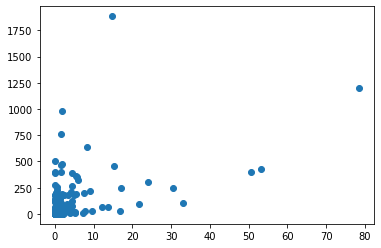

In [53]:
plt.scatter(current_day['built_percent_of_land_area'],current_day['cases_per_100k'])

# Choropleth maps

We wanted to give an overview of europe, so we created a layered choropleth maps, where you can choose between different statistics.

In [54]:
bins = list(current_day['pop_percentage_over_65'].quantile([0, 0.2, 0.4, 0.6,0.7,0.9, 1]))

m2 = folium.Map(location=[50.5260, 15.2551], zoom_start=4,zoom_control=False,
               scrollWheelZoom=False,
               dragging=False,
               doubleClickZoom=False,
               min_zoom =4,
               max_zoom =4)
folium.Choropleth(
    geo_data=country_geo,
    name='Population over 65',
    data=present_day,
    columns=[current_day.index,'pop_percentage_over_65'],
    key_on='properties.iso_a3',
    fill_color='OrRd',
    fill_opacity=0.5,
    line_opacity=0.2,
    bins=bins,
    legend_name='pop_percentage_over_65',
    show = False
).add_to(m2)


In [55]:
bins = list(current_day['gov_effectiveness'].quantile([0, 0.2, 0.4, 0.6,0.7,0.9, 1]))

#m2 = folium.Map(location=[48, -102], zoom_start=3)
folium.Choropleth(
    geo_data=country_geo,
    name='Government Effectiveness',
    data=present_day,
    columns=[current_day.index,'gov_effectiveness'],
    key_on='properties.iso_a3',
    fill_color='OrRd',
    fill_opacity=0.5,
    line_opacity=0.2,
    bins=bins,
    legend_name='Tourism',
    show = False
).add_to(m2)

In [56]:
bins = list(current_day['urban_pop_per_100k'].quantile([0, 0.2, 0.4, 0.6,0.7,0.9, 1]))

#m2 = folium.Map(location=[48, -102], zoom_start=3)
folium.Choropleth(
    geo_data=country_geo,
    name='Urban Population',
    data=present_day,
    columns=[current_day.index,'urban_pop_per_100k'],
    key_on='properties.iso_a3',
    fill_color='OrRd',
    fill_opacity=0.5,
    line_opacity=0.2,
    bins=bins,
    legend_name='Urban Population',
    smooth_factor = 0.01
).add_to(m2)
folium.LayerControl(collapsed=False).add_to(m2)

In [57]:
m2

In [58]:
m2.save("../Final project/website/folium/map2.html")

# Bookeh plots

We wanted to show a comparison between countries in terms of cases and deaths, and we wanted to show some other statistics as well.

We decided to do this through bookeh bar charts.

In [59]:
from bokeh.io import output_file, show, save, output_notebook
from bokeh.models import ColumnDataSource
from bokeh.models import FactorRange
from bokeh.plotting import figure
from bokeh.models import Legend
from bokeh.resources import CDN
from bokeh.embed import file_html

output_notebook() # for outputting to notebook
source = ColumnDataSource(current_day) # data importing
colors = ["#a83232", "#3283a8", "#a86932" , "#a8a232", "#7da832", "#32a83c"]#, "#32a87f", "#3283a8","#324aa8", "#5d32a8", "#9432a8", "#a83273", "#a83248", "#b59399", "#2e292a"]
data_to_show = ['deaths_per_100k','cases_per_100k']

selected_countries= ['AUT','BEL','DNK','FIN','FRA','DEU','IRL','ITA','LUX','NLD','PRT','ESP','SWE','GBR']

c = current_day.index.values.tolist()
countries=[]
for country in c:
    country =str(country)
    if country in selected_countries:
        countries.append(country)


p = figure(x_range = FactorRange(factors=countries), plot_height=400, plot_width=900, title="Countries, cases and deaths", 
           toolbar_location=None,  y_range = [10 ** 0, 640])
items=[]
bar ={} # to store vbars

for indx,i in enumerate(data_to_show):
    
    bar[i] = p.vbar(x='countryterritoryCode', top =i,  source= source, visible = True, width= 0.8, color =colors[indx], fill_alpha =0.6,bottom=0.01) 
    items.append((i, [bar[i]]))
    
#p.legend.click_policy="hide" ### assigns the click policy (you can try to use ''hide'
#p.legend.location = 'top_left'

legend = Legend(items=items, location=(0,0))
legend.click_policy="hide"

p.add_layout(legend, 'right')
p.xaxis.axis_label = "Country"
p.yaxis.axis_label = "Total Cases/Deaths"

#bar['deaths_per_100k'].visible = True 

show(p) #displays your plot


Loading BokehJS ...

In [60]:
#save the plot to html file

output_file("../Final project/website/folium/bookeh_bar_plot.html", mode='inline')
save(p)

'D:\\Social data 02806\\git\\Final project\\website\\folium\\bookeh_bar_plot.html'

In [61]:
output_notebook() # for outputting to notebook
source = ColumnDataSource(current_day) # data importing
colors = ["#a8a232", "#7da832", "#32a83c"]#, "#32a87f", "#3283a8","#324aa8", "#5d32a8", "#9432a8", "#a83273", "#a83248", "#b59399", "#2e292a"]
data_to_show = ['urban_pop_per_100k','pop_percentage_over_65_per_100k','tourists_per_100k']

selected_countries= ['AUT','BEL','DNK','FIN','FRA','DEU','IRL','ITA','LUX','NLD','PRT','ESP','SWE','GBR']

c = current_day.index.values.tolist()
countries=[]
for country in c:
    country =str(country)
    if country in selected_countries:
        countries.append(country)


p2 = figure(x_range = FactorRange(factors=countries), plot_height=400, plot_width=900, title="Country statistics", 
           toolbar_location=None,  y_range = [0, 3.5*(10 **5)])
items=[]
bar ={} # to store vbars

for indx,i in enumerate(data_to_show):
    
    bar[i] = p2.vbar(x='countryterritoryCode', top =i,  source= source, visible = True, width= 0.8, color =colors[indx], fill_alpha =0.6,bottom=0.01) 
    items.append((i, [bar[i]]))
    
#p.legend.click_policy="hide" ### assigns the click policy (you can try to use ''hide'
#p.legend.location = 'top_left'

legend = Legend(items=items, location=(0,0))
legend.click_policy="hide"

p2.add_layout(legend, 'right')
p2.xaxis.axis_label = "Country"
#p.yaxis.axis_label = "Total Cases"

bar['urban_pop_per_100k'].visible = True 

show(p2) #displays your plot


Loading BokehJS ...

In [62]:
#save the plot to html file

output_file("../Final project/website/folium/bookeh_bar_plot2.html", mode='inline')
save(p2)

'D:\\Social data 02806\\git\\Final project\\website\\folium\\bookeh_bar_plot2.html'